In [2]:
import torch
from torchsummary import summary
from collections import OrderedDict
from torchvision.models import VGG16_Weights
from SegNetModel import SegNet
import os

In [3]:
import sys
sys.path.append('/home/jupyter/work/resources/')

In [10]:
model = SegNet()

In [6]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

### Loading pre-trained weights(VGG16) into SegNet encoder

In [5]:
MODEL_WEIGHTS_DIR = './models/weights/'

In [6]:
def state_dict_name_modifier(state_dict: OrderedDict, model_state_dict: OrderedDict) -> OrderedDict:
    
    # Check which layer name pairs with my model layer name
    name_map = {}
    weight_name_size = [(k, v.shape) for k, v in state_dict.items()] 
    my_model_name_size = [(k, v.shape) for k, v in model_state_dict.items()]
    n, m = len(weight_name_size), len(my_model_name_size)
    i, j = 0, 0
    while i < n and j < m:
        if weight_name_size[i][0].startswith('classifier'): break
        while weight_name_size[i][1] != my_model_name_size[j][1]:
            j += 1    
        name_map[weight_name_size[i][0]] = my_model_name_size[j][0]
        i += 1
        
    # Rename pretraind layers
    renamed_state_dict = OrderedDict()
    for key, val in state_dict.items():
        if key.startswith('classifier'): break
        renamed_state_dict[name_map[key]] = val
    return renamed_state_dict

In [7]:
weights_path = MODEL_WEIGHTS_DIR + 'pretrained_encoder_weights_DEFAULT.pt'

In [11]:
# Skip this part if you already have renamed and saved model weights

if not os.path.isfile(weights_path):
    if not os.path.exists(MODEL_WEIGHTS_DIR):
        os.makedirs(MODEL_WEIGHTS_DIR)
    weights = VGG16_Weights.IMAGENET1K_V1
    state_dict = state_dict_name_modifier(torch.hub.load_state_dict_from_url(VGG16_Weights.IMAGENET1K_V1.url), model.encoder.state_dict())
    torch.save(state_dict, weights_path)

In [23]:
state_dict = torch.load(weights_path)

In [12]:
model.encoder.load_state_dict(state_dict, strict = False)

_IncompatibleKeys(missing_keys=['1.weight', '1.bias', '1.running_mean', '1.running_var', '4.weight', '4.bias', '4.running_mean', '4.running_var', '8.weight', '8.bias', '8.running_mean', '8.running_var', '11.weight', '11.bias', '11.running_mean', '11.running_var', '15.weight', '15.bias', '15.running_mean', '15.running_var', '18.weight', '18.bias', '18.running_mean', '18.running_var', '21.weight', '21.bias', '21.running_mean', '21.running_var', '25.weight', '25.bias', '25.running_mean', '25.running_var', '28.weight', '28.bias', '28.running_mean', '28.running_var', '31.weight', '31.bias', '31.running_mean', '31.running_var', '35.weight', '35.bias', '35.running_mean', '35.running_var', '38.weight', '38.bias', '38.running_mean', '38.running_var', '41.weight', '41.bias', '41.running_mean', '41.running_var'], unexpected_keys=[])

In [86]:
from torchvision import transforms
transform_train = transforms.Compose([
    transforms.Resize([224, 224]),
    #transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406, 0.5), (0.229, 0.224, 0.225, 0.5)),
    transforms.RandomRotation(random.randint(0, 180))])

In [46]:
from PIL import Image

In [48]:
image = Image.open('./datasets/segNet/images/1.jpg')
mask = Image.open('./datasets/segNet/mask/1.png')

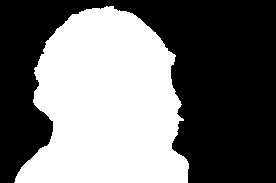

In [60]:
mask

In [130]:
m = torch.as_tensor(np.array(mask))

In [131]:
m.max()

tensor(255, dtype=torch.uint8)

In [64]:
tr = transforms.ToTensor()

In [65]:
im = tr(image)

In [66]:
ms = tr(mask)

In [ ]:
transforms.ToTensor(mask)

In [123]:
ms8 = tr(Image.open('./datasets/segNet/mask/2.png'))

In [127]:
image8 = tr(Image.open('./datasets/segNet/images/8.jpg'))

In [128]:
image8.max()

tensor(1.)

In [124]:
ms8.max()

tensor(1.)

In [68]:
tmp = transforms.Resize([224, 224])

In [71]:
tr(tmp(image)).shape

torch.Size([3, 224, 224])

In [67]:
print(im.shape, ms.shape)

torch.Size([3, 183, 276]) torch.Size([1, 183, 276])


In [73]:
im1 = im.unsqueeze(0)

In [74]:
ms1 = ms.unsqueeze(0)
ms1.shape

torch.Size([1, 1, 183, 276])

In [ ]:
ms

In [75]:
im1.shape

torch.Size([1, 3, 183, 276])

In [78]:
both = torch.cat((im, ms), dim = 0)

In [ ]:
res = transform_train(both)

In [100]:
im2, ms2 = torch.tensor_split(res,[3], dim = 0)

In [92]:
import numpy as np

In [101]:
im2.shape

torch.Size([3, 224, 224])

In [113]:
def conv_to_img(tensor: torch.tensor) -> np.array:
    """Convert image to display by pyplot."""
    img = tensor.to('cpu').clone().detach()
    img = img.numpy().squeeze()
    #img = img.transpose(1, 2, 0)
    #img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    img = img.clip(0, 1)
    return img


In [105]:
pic = conv_to_img(im2)

In [114]:
picm = conv_to_img(ms2)

In [108]:
import matplotlib.pyplot as plt

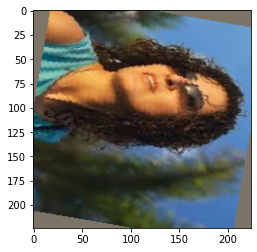

In [109]:
plt.imshow(pic)

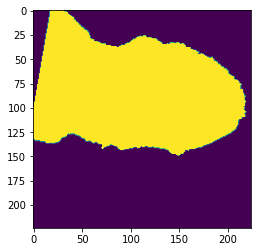

In [116]:
plt.imshow(picm)

In [121]:
ms2.max()

tensor(1.)

In [ ]:
transform_train(image, mask)

In [54]:
import torchvision
torchvision.__version__

'0.15.2+cu118'

In [ ]:
from torchvision.transforms import v2